In [1]:
import cv2
import numpy as np
import csv
from pathlib import Path
from mtcnn import MTCNN
from tqdm import tqdm
import pandas as pd

In [2]:
CSV_PATH = r"C:\Users\TanPhat\Documents\DEEPLEARNING\deepfake_detection\preprocessing\balanced_videos.csv"     # CSV: video_path, label (real/fake)
VIDEO_ROOT = Path(r"C:\Users\TanPhat\Documents\DEEPLEARNING\deepfake_detection\data\Celeb-DF-v2")
OUTPUT_DIR = Path("output_faces")

In [3]:
IMAGE_SIZE = 224
FRAMES_PER_VIDEO = 8          
CONF_THRESH = 0.90
MARGIN = 0.15               
MIN_FRAMES_PER_VIDEO = 6

LABEL_MAP = {
    "real": "real",
    "fake": "fake",
    0: "fake",
    1: "real",
}

In [4]:
MIN_FACE_SIZE = 80    
MAX_FACE_SIZE = 400    
ASPECT_RATIO_MIN = 0.7    
ASPECT_RATIO_MAX = 1.5  

In [5]:
# FACE EXTRACTOR 
class FaceExtractor:
    def __init__(self):
        self.detector = MTCNN()

    def _valid_box(self, box):
        x, y, w, h = box
        if w < MIN_FACE_SIZE or h < MIN_FACE_SIZE:
            return False
        if w > MAX_FACE_SIZE or h > MAX_FACE_SIZE:
            return False
        ar = w / h if h > 0 else 0
        return 0.6 <= ar <= 1.6

    def crop_face(self, img, box):
        h, w, _ = img.shape
        x, y, bw, bh = box

        if not self._valid_box(box):
            return None

        mx, my = int(bw * MARGIN), int(bh * MARGIN)
        x1 = max(0, x - mx)
        y1 = max(0, y - my)
        x2 = min(w, x + bw + mx)
        y2 = min(h, y + bh + my)

        face = img[y1:y2, x1:x2]
        if face.size == 0:
            return None

        return cv2.resize(face, (IMAGE_SIZE, IMAGE_SIZE))

    def detect(self, frame_rgb):
        faces = self.detector.detect_faces(frame_rgb)
        if not faces:
            return None, 0.0

        best = max(faces, key=lambda x: x["confidence"])
        conf = best["confidence"]

        if conf < CONF_THRESH:
            return None, conf

        face = self.crop_face(frame_rgb, best["box"])
        return face, conf


In [6]:
#  UTILS 
def sample_frames(cap, n):
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total <= 0:
        return []
    return np.linspace(0, total - 1, n, dtype=int)

In [7]:
# VIDEO PROCESS

def process_video(video_path, label_name, extractor, writer, save_root):
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        return 0

    frame_ids = sample_frames(cap, FRAMES_PER_VIDEO)
    saved = 0

    for idx, fid in enumerate(frame_ids):
        cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
        ret, frame = cap.read()
        if not ret:
            continue

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        face, conf = extractor.detect(rgb)

        if face is None:
            continue

        # save image
        out_dir = save_root / label_name / video_path.stem
        out_dir.mkdir(parents=True, exist_ok=True)
        cv2.imwrite(
            str(out_dir / f"frame_{saved:03d}.jpg"),
            cv2.cvtColor(face, cv2.COLOR_RGB2BGR),
        )

        writer.writerow([
            video_path.name, fid, label_name, round(conf, 4)
        ])

        saved += 1

    cap.release()
    return saved


 FACE EXTRACTION STARTED
 Videos in CSV: 2090


100%|██████████| 2090/2090 [5:01:05<00:00,  8.64s/it]      



 FINAL EXTRACTION STATISTICS
REAL  | Videos:   17 | Frames:     52 | Avg/video: 3.06
FAKE  | Videos: 1422 | Frames:  11169 | Avg/video: 7.85


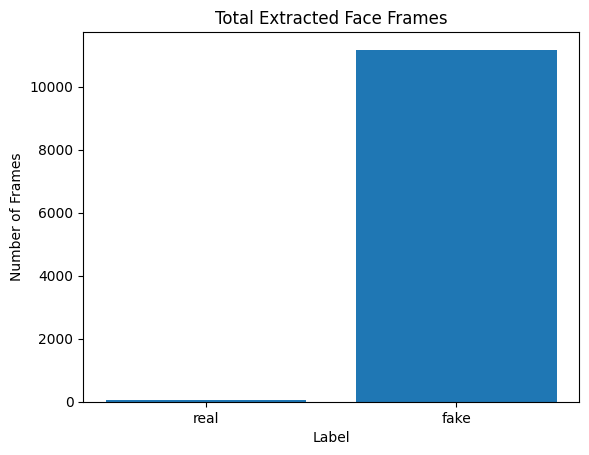

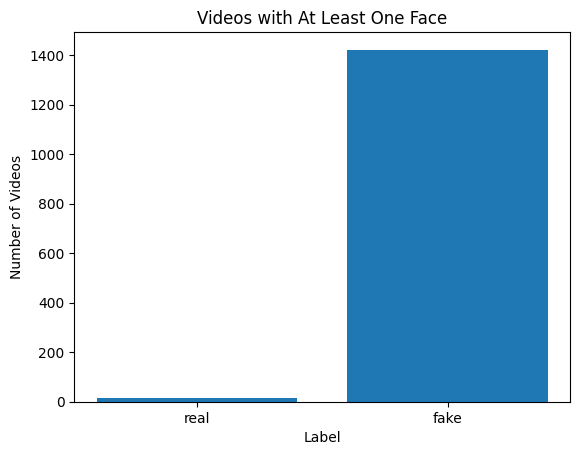


 DONE
 Output saved to: output_faces


In [8]:
#  MAIN PIPELINE

from collections import defaultdict
import matplotlib.pyplot as plt

def plot_after_extraction(stats):
    labels = ["real", "fake"]
    frames = [stats[l]["frames"] for l in labels]
    videos = [stats[l]["videos"] for l in labels]

    plt.figure()
    plt.bar(labels, frames)
    plt.title("Total Extracted Face Frames")
    plt.ylabel("Number of Frames")
    plt.xlabel("Label")
    plt.show()

    plt.figure()
    plt.bar(labels, videos)
    plt.title("Videos with At Least One Face")
    plt.ylabel("Number of Videos")
    plt.xlabel("Label")
    plt.show()


def main():
    df = pd.read_csv(CSV_PATH)
    assert {"video_path", "label"}.issubset(df.columns)

    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    (OUTPUT_DIR / "real").mkdir(exist_ok=True)
    (OUTPUT_DIR / "fake").mkdir(exist_ok=True)

    # ===== stats =====
    stats = {
        "real": {"videos": 0, "frames": 0},
        "fake": {"videos": 0, "frames": 0},
    }

    meta_file = open(OUTPUT_DIR / "meta.csv", "w", newline="", encoding="utf-8")
    writer = csv.writer(meta_file)
    writer.writerow([
        "video",
        "frame_id",
        "timestamp",
        "label",
        "image_path",
        "confidence"
    ])

    extractor = FaceExtractor()

    print("=" * 70)
    print(" FACE EXTRACTION STARTED")
    print(f" Videos in CSV: {len(df)}")
    print("=" * 70)

    for _, row in tqdm(df.iterrows(), total=len(df)):
        raw_path = str(row["video_path"]).strip().replace("/", "\\")
        video_path = Path(raw_path)

        if not video_path.is_absolute():
            video_path = VIDEO_ROOT / video_path

        if not video_path.exists():
            print(f" Missing video: {video_path}")
            continue

        raw_label = str(row["label"]).strip().lower()
        label_name = LABEL_MAP[raw_label]
        # RESUME LOGIC 
        video_out_dir = OUTPUT_DIR / label_name / video_path.stem
        if video_out_dir.exists():
            existing_frames = list(video_out_dir.glob("*.jpg"))
            if len(existing_frames) >= MIN_FRAMES_PER_VIDEO:
                continue

        frames_saved = process_video(
            video_path=video_path,
            label_name=label_name,
            extractor=extractor,
            writer=writer,
            save_root=OUTPUT_DIR,
        )

        # update stats 
        if frames_saved > 0:
            stats[label_name]["videos"] += 1
            stats[label_name]["frames"] += frames_saved

    meta_file.close()

    # ===== PRINT FINAL STATS =====
    print("\n FINAL EXTRACTION STATISTICS")
    print("=" * 40)
    for lbl in ["real", "fake"]:
        v = stats[lbl]["videos"]
        f = stats[lbl]["frames"]
        avg = f / v if v > 0 else 0
        print(f"{lbl.upper():5s} | Videos: {v:4d} | Frames: {f:6d} | Avg/video: {avg:.2f}")

    # ===== PLOT AFTER EVERYTHING IS DONE =====
    plot_after_extraction(stats)

    print("\n DONE")
    print(f" Output saved to: {OUTPUT_DIR}")


# ================= RUN =================

if __name__ == "__main__":
    main()
